<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/

# **Coleta de dados do Kaglle**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **###  Download dos dados / descompactando os dados**

In [5]:
!kaggle datasets download fabiobasson/geologicalsimilarity
! unzip -qq  geologicalsimilarity

  0% 0.00/1.31M [00:00<?, ?B/s]
100% 1.31M/1.31M [00:00<00:00, 43.3MB/s]


# ** Criação da estrutura **

In [75]:
andesite_dir = glob.glob('andesite/*.jpg');gneiss_dir = glob.glob('gneiss/*.jpg')
marble_dir= glob.glob('marble/*.jpg');quartzite_dir = glob.glob('quartzite/*.jpg')
rhyolite_dir = glob.glob('rhyolite/*.jpg');
schist_dir = glob.glob('schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


230
190
204
198
198
204


# **Nomes das Classes**
# andesite = 0  # gneiss =1 # marbler = 2 # quartzite = 3 # rhyolite = 4  # schist = 5 


In [7]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']

# label =[0,1,2,3,4,5]

In [8]:
andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

for i in andesite_dir:
    andesite_df.append([i,class_names[0]])
for j in gneiss_dir:
   gneiss_df.append([j,class_names[1]])
for l in marble_dir:
    marble_df.append([l,class_names[2]])
for m in quartzite_dir:
    quartzite_df.append([m,class_names[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,class_names[4]])
for o in schist_dir:
    schist_df.append([o,class_names[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)

1218

# **Normalização dos dados**

In [115]:
import cv2 as cv
import glob

path="andesite/*.jpg" # Lê o Diretorio Andesite de Imagens

for img in glob.glob("andesite/*.jpg, gneiss/*.jpg, marble/*.jpg, quartzite/*.jpg, rhyolite/*.jpg,  schist/*.jpg"):
    img = cv.imread(img)  # Lê a imgem
    img = img.astype('float32')/255. #normaliza entre 0 e 1                              
img                     

array([[[0.4862745 , 0.45882353, 0.42352942],
        [0.5568628 , 0.5254902 , 0.49803922],
        [0.58431375, 0.54901963, 0.5372549 ],
        ...,
        [0.44313726, 0.46666667, 0.3764706 ],
        [0.49803922, 0.50980395, 0.42352942],
        [0.47058824, 0.4862745 , 0.3882353 ]],

       [[0.4392157 , 0.4117647 , 0.3764706 ],
        [0.5529412 , 0.52156866, 0.49411765],
        [0.6784314 , 0.6431373 , 0.6313726 ],
        ...,
        [0.48235294, 0.5058824 , 0.41568628],
        [0.47843137, 0.49411765, 0.39607844],
        [0.45490196, 0.4745098 , 0.36862746]],

       [[0.50980395, 0.4745098 , 0.4392157 ],
        [0.46666667, 0.42745098, 0.4       ],
        [0.5921569 , 0.54509807, 0.5372549 ],
        ...,
        [0.45490196, 0.47843137, 0.38039216],
        [0.44705883, 0.46666667, 0.3529412 ],
        [0.35686275, 0.37254903, 0.25882354]],

       ...,

       [[0.6509804 , 0.61960787, 0.5686275 ],
        [0.65882355, 0.6313726 , 0.57254905],
        [0.61960787, 0

In [70]:
#from skimage.io import imread_collection

#your path 
#col_dir = 'andesite/*.jpg'

#creating a collection with the available images
#col = imread_collection(col_dir)
#print(col[0])


In [9]:
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,rhyolite/1BQQM.jpg,rhyolite
1,rhyolite/1G39Y.jpg,rhyolite
2,quartzite/0RQA4.jpg,quartzite
3,schist/00TOX.jpg,schist
4,andesite/2B375.jpg,andesite
...,...,...
1213,andesite/0N8VN.jpg,andesite
1214,schist/1Y8DC.jpg,schist
1215,marble/0U0EL.jpg,marbler
1216,gneiss/01NQL.jpg,gneiss


#  Conhecendo os dados de imagem

uint8
(28, 28, 3)
251
32


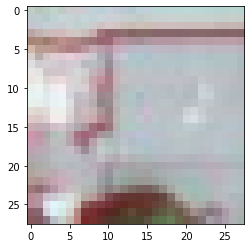

In [113]:
from matplotlib import image
from matplotlib import pyplot
# Carregando imagem como um array NumPy:
data = image.imread("gneiss/0QTQE.jpg")
# Imprimindo as propriedades do array de pixels:
print(data.dtype)
print(data.shape)
print(data.max())
print(data.min())

# Exibindo o array de pixels como uma imagem:
pyplot.imshow(data)

In [11]:
from numpy import asarray
image = Image.open("gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
print(pixels)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

[[[192 205 196]
  [184 197 188]
  [186 203 193]
  ...
  [184 210 207]
  [186 212 209]
  [185 211 208]]

 [[190 201 205]
  [188 203 206]
  [181 201 202]
  ...
  [195 206 202]
  [198 207 202]
  [197 206 201]]

 [[198 196 207]
  [194 201 209]
  [196 207 211]
  ...
  [196 181 178]
  [198 183 180]
  [196 181 176]]

 ...

 [[183 139 152]
  [177 149 163]
  [225 221 235]
  ...
  [184 177 185]
  [182 183 188]
  [174 179 183]]

 [[141  95 106]
  [134 102 115]
  [212 206 218]
  ...
  [170 154 165]
  [178 176 181]
  [171 177 177]]

 [[134  89  92]
  [126  89  97]
  [140 120 132]
  ...
  [170 160 171]
  [175 176 180]
  [164 175 171]]]
Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Separação das amostras**

In [10]:
X = data_df.drop(columns='label')
y = data_df.path

# **Criando o Dataframe**

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=44)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(974, 1)
(244, 1)
(974,)
(244,)


# **Explorando os dados**

# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

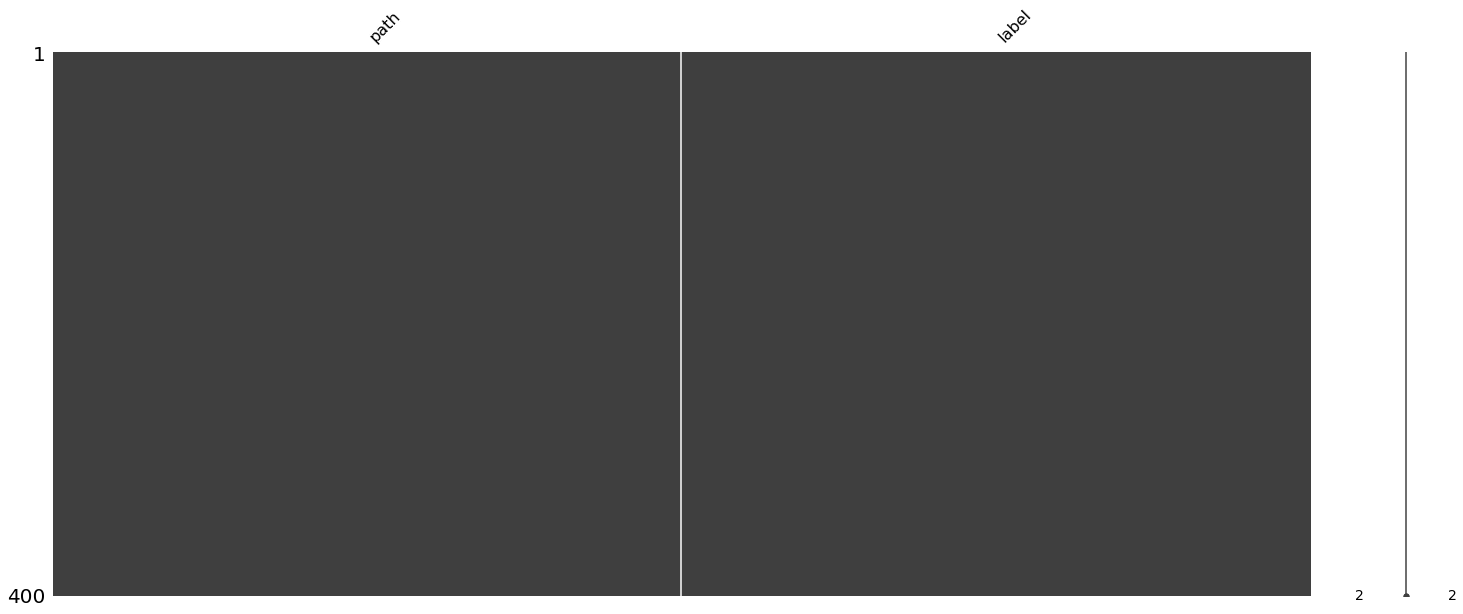

In [13]:
import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [ ]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [15]:
IMG_SHAPE = 28
BATCH_SIZE = 20

In [16]:
datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            #vertical_flip =False , 
                            validation_split=0.2)

In [17]:
train_generator = datagen.flow_from_dataframe(data_df,
                                              x_col='path',
                                              y_col='label',
                                              images_size=(28,28),
                                              #class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(28,28),
                                                   #class_mode='binary',
                                                   subset='validation')

## Duvidas - Existe esse codigo abaixo

test_generator = datagen.flow_from_dataframe(data_df,
                                             x_col='path',
                                             y_col='label',
                                             images_size=(28,28),
                                             #class_mode='binary',
                                             )

Found 975 validated image filenames belonging to 6 classes.
Found 243 validated image filenames belonging to 6 classes.
Found 1218 validated image filenames belonging to 6 classes.


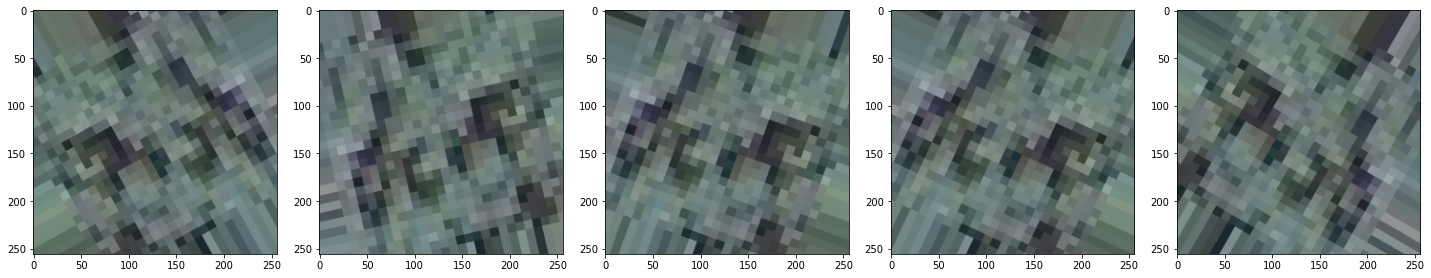

In [18]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Pre Processamento dos dados**

# **Criar o modelo**

In [32]:
inputs = tf.keras.Input(shape=(256, 256,3))
# x = augmented_images(inputs) # como conserto e passo isso
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


TypeError: ignored

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1)
])

# **Compilando o Modelo**

In [20]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [21]:
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      147520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [22]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

# **Avaliar o modelo**

In [1]:
history = model.fit(train_generator,
                               epochs=40,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               #workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

NameError: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Otimizar o modelo**

# **Avaliar acurácia  do Modelo**

In [2]:
model = tf.keras.models.load_model("best_model.h5")

val_acc = model.evaluate(test_generator)[1]
print("validation_accuracy: " + str(val_acc))

NameError: ignored

# **Realizar a Predição**

In [ ]:
img_pred = cv2.imread("gneiss/0QTQE.jpg", 0)
plt.imshow(img_pred, cmap='gray')

if img_pred.shape != [28,28]:
    img2 = cv2.resize(img_pred, (28, 28))
    img_pred = img2.reshape(28, 28, -1)
else:
    img_pred = img_pred.reshape(28, 28, -1)

img_pred = ~img_pred
img_pred = img_pred.reshape(1, 1, 28, 28).astype('float32')

img_pred = img_pred/255.0


pred = model.predict_classes(img_pred)
pred_proba = model.predict_proba(img_pred)
pred_proba = "%.2f%%" % (pred_proba[0][pred]*100)
print(pred[0], " com confiança de ", pred_proba)